In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

ModuleNotFoundError: No module named 'plotly'

In [7]:
df_data = pd.read_csv("Country-data.csv")
df_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [8]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


###### We do no have amy missing values. NO missing value treatment is required in this case

In [9]:
#removing the column country
data = df_data.drop('country', axis = 1)

In [10]:
#exports, health and imports are given as % of GDP Percapita.
#Converting percentages to values
data.exports = (data.exports / 100 ) * (data.gdpp)
data.health = (data.health / 100 ) * (data.gdpp)
data.imports = (data.imports / 100 ) * (data.gdpp)

In [11]:
#Maing sure the changes are done
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


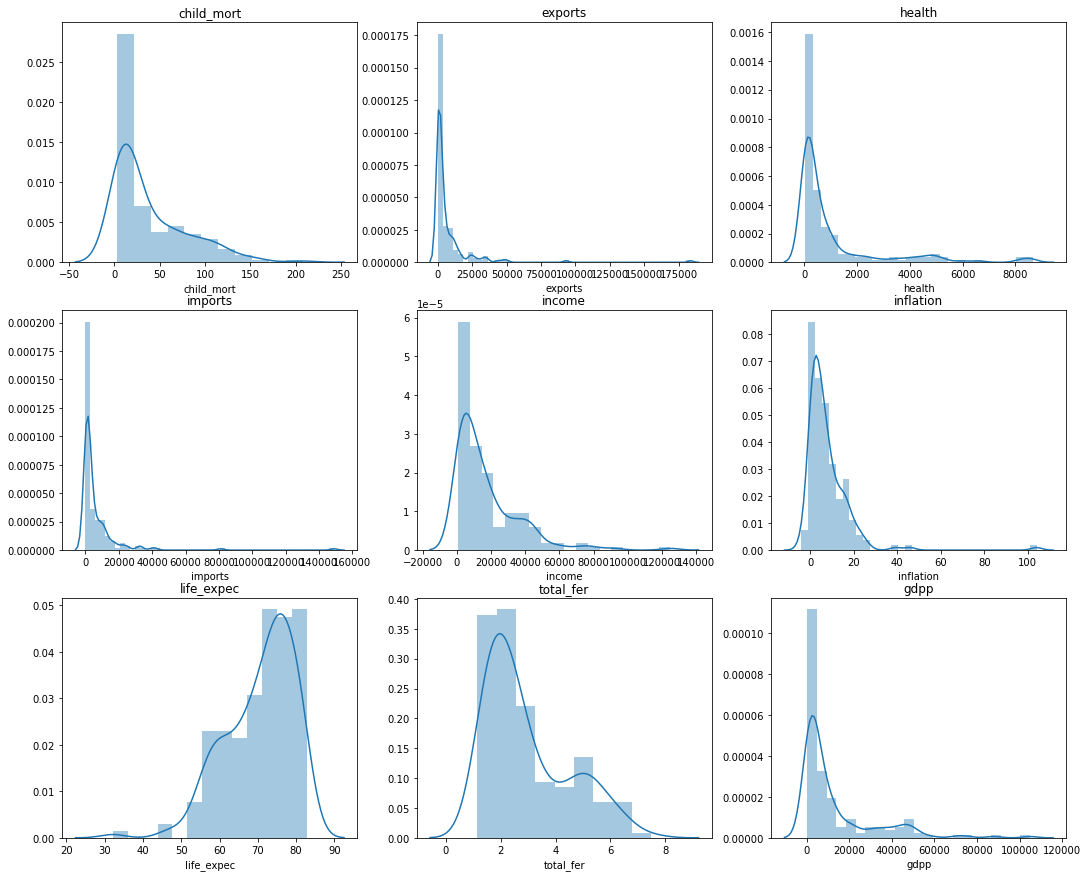

In [12]:

plt.figure(figsize=(18,15))
features = data.columns
for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(data[i[1]])
    plt.title(str(i[1]))

* Skewness is present in all variables
* Mostly allof them are skewed towards right , except **life_expec** (which is left skewed)
* This indicates that there are outliers which are meaningful

In [13]:
#checking skewness of each feature before transforming the data
data.skew()

child_mort    1.450774
exports       6.720171
health        2.526029
imports       6.618500
income        2.231480
inflation     5.154049
life_expec   -0.970996
total_fer     0.967092
gdpp          2.218051
dtype: float64

In [14]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
transformed_data = pd.DataFrame(pt.fit_transform(data))
transformed_data.columns= data.columns

In [15]:
transformed_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228


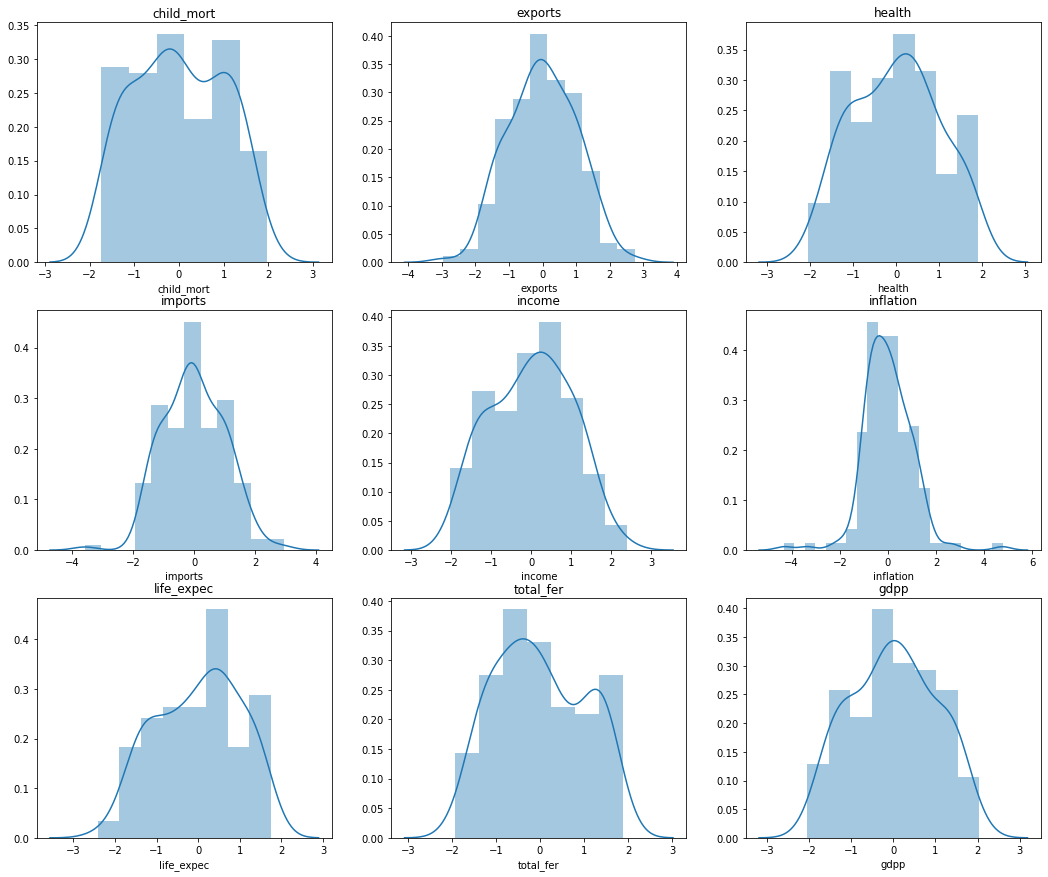

In [16]:
#Plotting all the features to visualise and look their distributions
plt.figure(figsize=(18,15))
features = transformed_data.columns
for i in enumerate(features):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(transformed_data[i[1]])
    plt.title(str(i[1]))

In [17]:
#skewness of each feature after transforming the data
transformed_data.skew()

child_mort    0.015754
exports      -0.011631
health        0.028684
imports       0.008375
income       -0.035867
inflation     0.182506
life_expec   -0.184956
total_fer     0.136536
gdpp          0.001120
dtype: float64

## K-means Implementation

In [18]:
#Finding Optimal number of Clusters using elbow methed
cluster_range = range( 1, 15)
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters, n_init = 100,init='k-means++',random_state=0)
  clusters.fit(transformed_data)
  labels = clusters.labels_                     # capture the cluster lables
  centroids = clusters.cluster_centers_         # capture the centroids
  cluster_errors.append( clusters.inertia_ )    # capture the intertia
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors} )
clusters_df[0:10] 

NameError: name 'KMeans' is not defined

In [19]:
# Elbow plot

plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.xlabel("Number of Clusters")
plt.ylabel("Cluster Errors")
plt.title("Elbow Curve")
plt.show()

NameError: name 'clusters_df' is not defined

<Figure size 864x432 with 0 Axes>

#### From the above Elbow plot, we found that Optimal number of Clusters = 3
#### Implementing K-Means with number of clusters as "3"

In [24]:
# Number of clusters = 3
kmeans = KMeans(n_clusters=3,n_init = 100,init='k-means++',random_state=0)
# Fitting the input data
kmeans = kmeans.fit(transformed_data)
# Getting the cluster labels
labels = kmeans.predict(transformed_data)
# Centroid values
centroids = kmeans.cluster_centers_

NameError: name 'KMeans' is not defined

In [20]:
kmeans_final = pd.DataFrame(transformed_data, columns= transformed_data.columns)
kmeans_final["kmeans_grp"] = labels
df_data["kmeans_grp"] = labels

In [18]:
kmeans_final.head(10)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_grp
0,1.266699,-1.658719,-1.239313,-1.246055,-1.368935,0.459416,-1.526455,1.544053,-1.462273,0
1,-0.220994,-0.238427,-0.042924,-0.055108,0.012538,-0.154659,0.621738,-0.992833,-0.121133,1
2,0.217834,-0.030785,-0.270052,-0.266188,0.232275,1.059790,0.652698,0.313175,-0.063195,1
3,1.506186,0.100544,-0.661987,-0.219429,-0.408251,1.512843,-1.239045,1.623128,-0.219666,0
4,-0.637380,0.602677,0.563269,0.758134,0.572583,-0.723442,0.699553,-0.368063,0.609228,2
5,-0.339697,0.036270,0.636466,-0.168627,0.553895,1.412022,0.545301,-0.120706,0.496207,1
6,-0.144877,-0.508145,-0.442152,-0.241864,-0.307448,0.275860,0.183248,-0.932506,-0.281188,1
7,-1.277117,0.950906,1.572599,1.032075,1.282892,-0.793127,1.594457,-0.604207,1.574088,2
8,-1.364807,1.451427,1.640826,1.531545,1.323552,-0.870154,1.319778,-1.341021,1.506685,2
9,0.537221,0.296020,0.109133,-0.353539,0.417398,0.870730,-0.353603,-0.616839,0.117089,1


### Hierarchical Clustering

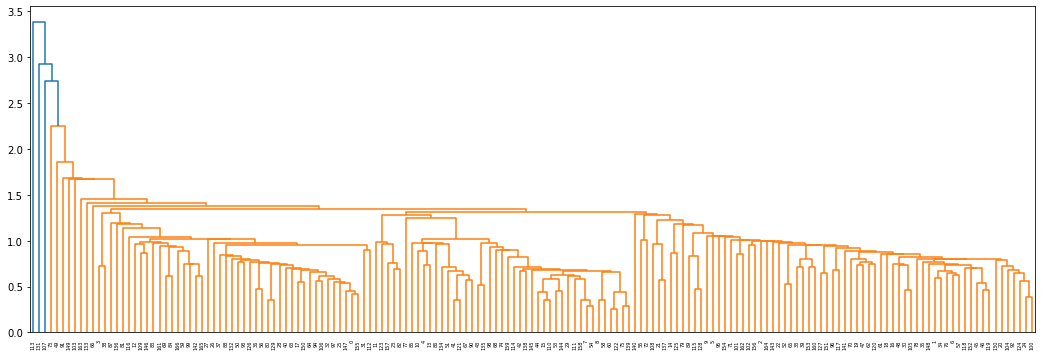

In [21]:
# single linkage
plt.figure(figsize=(18,6))
single_link = linkage(transformed_data, method="single", metric='euclidean')
dendrogram(single_link)
plt.show()

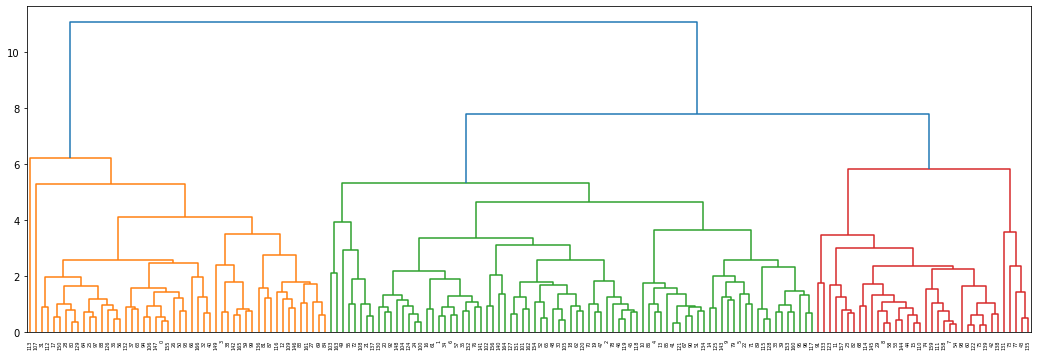

In [22]:
# complete linkage
plt.figure(figsize=(18,6))
complete_link = linkage(transformed_data, method="complete", metric='euclidean')
dendrogram(complete_link)
plt.show()

In [23]:
# 3 clusters
heirarchical_labels = cut_tree(complete_link, n_clusters=3).reshape(-1, )
heirarchical_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 2,
       0, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 1, 0, 0])

In [24]:
heirarchical_final = pd.DataFrame(transformed_data, columns= transformed_data.columns)
heirarchical_final["h_grp"] = heirarchical_labels
df_data["h_grp"] = heirarchical_labels

In [1]:
px.scatter(transformed_data, x="child_mort", y="gdpp", color="kmeans_grp")

NameError: name 'px' is not defined

In [26]:
px.scatter(transformed_data, x="gdpp", y="income", color="kmeans_grp")

In [28]:
px.scatter(transformed_data, x="child_mort", y="income", color="kmeans_grp")

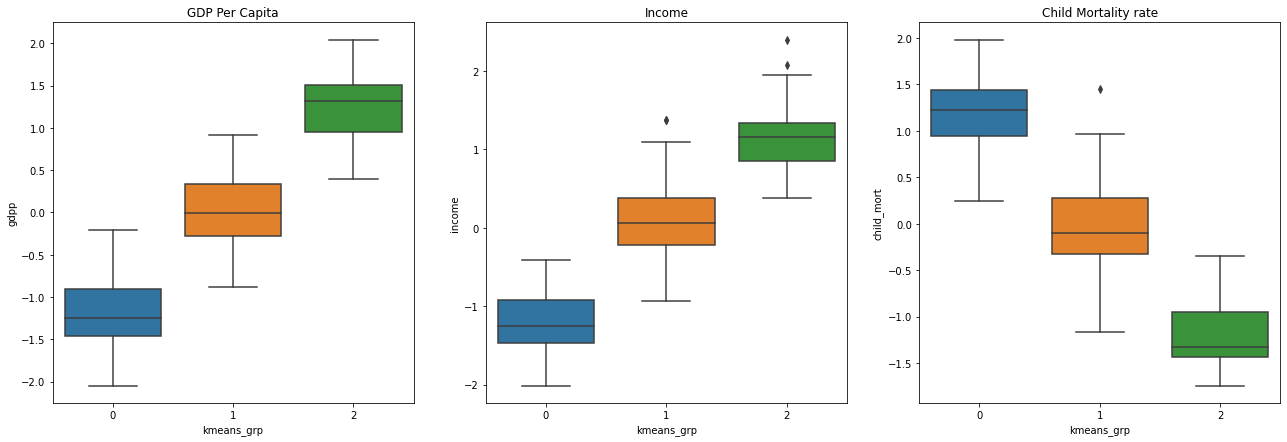

In [39]:
#Plotting box plots of all clusters formed
plt.figure(figsize=(22,7))
plt.subplot(1,3,1)
sns.boxplot(x='kmeans_grp', y='gdpp', data=transformed_data)
plt.title("GDP Per Capita")
plt.subplot(1,3,2)
sns.boxplot(x='kmeans_grp', y='income', data=transformed_data)
plt.title("Income")
plt.subplot(1,3,3)
sns.boxplot(x='kmeans_grp', y='child_mort', data=transformed_data)
plt.title("Child Mortality rate")
plt.show()

## Clusters Formed
* From the above box plots and scatter plots , we could see that :
* **Group - 0** : *High Child Mortality, Low Income and Low GDP
* **Group - 1** : *Average Child Mortality, Average Income and Average GDP
* **Group - 2** : *Low Child Mortality, High Income and High GDP

In [44]:
df_data[df_data.kmeans_grp==0].sort_values(by=["income","gdpp","child_mort"]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_grp,h_grp
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,0,0
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,0,0
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,0,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,0,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,0,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,0,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,0,0
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648,0,0
150,Togo,90.3,40.20,7.65,57.3,1210,1.18,58.7,4.87,488,0,0
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,0,0


In [45]:
df_data[df_data.h_grp==0].sort_values(by=["income","gdpp","child_mort"]).head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_grp,h_grp
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334,0,0
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327,0,0
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231,0,0
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348,0,0
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446,0,0
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419,0,0
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459,0,0
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648,0,0
150,Togo,90.3,40.20,7.65,57.3,1210,1.18,58.7,4.87,488,0,0
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399,0,0


In [46]:
df_data[df_data.kmeans_grp != df_data.h_grp]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,kmeans_grp,h_grp
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,2,1
10,Bahamas,13.8,35.0,7.89,43.7,22900,-0.393,73.8,1.86,28000,2,1
13,Barbados,14.2,39.5,7.97,48.7,15300,0.321,76.7,1.78,16000,2,1
41,Croatia,5.5,37.6,7.76,38.1,20100,0.821,76.3,1.55,13500,2,1
51,Estonia,4.5,75.1,6.03,68.7,22700,1.740,76.0,1.72,14600,2,1
67,Hungary,6.0,81.8,7.33,76.5,22300,2.330,74.5,1.25,13100,2,1
85,Latvia,7.8,53.7,6.68,55.1,18300,-0.812,73.1,1.36,11300,2,1
86,Lebanon,10.3,35.8,7.03,60.2,16300,0.238,79.8,1.61,8860,2,1
90,Lithuania,6.1,65.3,7.04,67.2,21100,2.380,73.2,1.50,12000,2,1
121,Poland,6.0,40.1,7.46,42.1,21800,1.660,76.3,1.41,12600,2,1


#### From above comparision,  we could see there some countries are classified under group 2 in KMeans is classified as Group 1 in Heirarchical clustering